Initialisation 

In [167]:
# pip install networkx
# pip install pyproj

import pandas as pd
import csv
import math
import networkx as nx 
import heapq

# numpy pour dijkstra 
import numpy as np
from numpy import Inf

#Widget
import ipywidgets as widgets
from IPython.display import display

#Map interactive
import folium as f
from folium.plugins import MarkerCluster

#Map pour connection
import matplotlib.pyplot as plt
%matplotlib inline

#Calcul great circle
import pyproj


#import os
#import flightradar24

## Regles de codage 


In [168]:
'''
type_nom_variable
nomFonction(nom_variable : type) 
\'''
    description
    retour :  avec un exemple de forme 
\'''

aeroport ipv airports 
vol --> routesANLO --> df_vols
routes --> dict_routes 

'''

"\ntype_nom_variable\nnomFonction(nom_variable : type) \n'''\n    description\n    retour :  avec un exemple de forme \n'''\n\naeroport ipv airports \nvol --> routesANLO --> df_vols\nroutes --> dict_routes \n\n"

## Importation des données

In [169]:
chemin="../data/"

#df_aeroports = pd.read_csv(chemin + "aeroportsANLO.csv")
#df_zones = pd.read_csv(chemin + "zonesANLO.csv")
df_vols = pd.read_csv(chemin + "routesANLO.csv")
#df_compagnies = pd.read_csv(chemin + "compagniesANLO.csv")

In [170]:
dict_compagnies = {}

with open(chemin+'compagniesANLO.csv', mode='r') as inp:
    reader = csv.reader(inp)
    next(reader, None)
    headers = ['Name','Country']
    dict_compagnies = {rows[2]:dict(zip(headers,[rows[0],rows[3]])) for rows in reader}


In [171]:
dict_aeroports = {}

with open(chemin+'aeroportsANLO.csv', mode='r') as inp:
    reader = csv.reader(inp)
    headers = next(reader, None)
    dict_aeroports = {rows[1]:dict(zip(headers,rows[0:8])) for rows in reader}

dict_aeroports['CDG']

{'Name': 'Paris Charles de Gaulle Airport',
 'Iata': 'CDG',
 'Icao': 'LFPG',
 'Lat': '49.012516',
 'Lon': '2.555752',
 'Country': 'France',
 'Alt': '392',
 'City': 'Paris'}

In [172]:
dict_pays = {}

with open(chemin+'countries.csv', mode='r') as inp:
    reader = csv.reader(inp)
    headers = next(reader, None)
    dict_pays = {rows[1]:rows[0] for rows in reader}

dict_pays

{'Algeria': 'Africa',
 'Angola': 'Africa',
 'Benin': 'Africa',
 'Botswana': 'Africa',
 'Burkina Faso': 'Africa',
 'Burundi': 'Africa',
 'Cameroon': 'Africa',
 'Cape Verde': 'Africa',
 'Central African Republic': 'Africa',
 'Chad': 'Africa',
 'Comoros': 'Africa',
 'Congo': 'Africa',
 'Democratic Republic Of The Congo': 'Africa',
 'Djibouti': 'Africa',
 'Egypt': 'Africa',
 'Equatorial Guinea': 'Africa',
 'Eritrea': 'Africa',
 'Ethiopia': 'Africa',
 'Gabon': 'Africa',
 'Gambia': 'Africa',
 'Ghana': 'Africa',
 'Guinea': 'Africa',
 'Guinea-Bissau': 'Africa',
 "Cote D'ivoire (Ivory Coast)": 'Africa',
 'Kenya': 'Africa',
 'Lesotho': 'Africa',
 'Liberia': 'Africa',
 'Libya': 'Africa',
 'Madagascar': 'Africa',
 'Malawi': 'Africa',
 'Mali': 'Africa',
 'Mauritania': 'Africa',
 'Mauritius': 'Africa',
 'Morocco': 'Africa',
 'Mozambique': 'Africa',
 'Namibia': 'Africa',
 'Niger': 'Africa',
 'Nigeria': 'Africa',
 'Rwanda': 'Africa',
 'Sao Tome And Principe': 'Africa',
 'Senegal': 'Africa',
 'Seychell

In [173]:
df_vols = df_vols[["Depart","Arrivee","Code_ICAO"]].dropna()

In [174]:
#Nettoyage de la df_vols
for _, ligne in df_vols.iterrows():
    if not(ligne.Depart in dict_aeroports):
        df_vols.drop(df_vols[df_vols['Depart'] == ligne.Depart].index, inplace=True)
    
    if not(ligne.Arrivee in dict_aeroports):
        df_vols.drop(df_vols[df_vols['Arrivee'] == ligne.Arrivee].index, inplace=True)

In [175]:
def coordDepuisAeroport(iata : str):
    '''
    Fonction : Recherche les coordonnées GPS d'un aéroport
    Retour : lat : float ,lon : float --> Latitude & longitude de l'aéroport
    '''
    lat = float(dict_aeroports[iata]['Lat'])
    lon = float(dict_aeroports[iata]['Lon'])
    return lat,lon

def DistGrandCercle(lat1 : float, lon1 : float, lat2 : float, lon2 : float):
    #Conversion en radian
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    #Delta des coordonnées
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    #Rayon terrestre (en km)
    r = 6367.0

    #Formule d'Haversine
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    return 2 * r * math.asin(math.sqrt(a))


def DistGrandCercleICAO(icao1 : str, icao2 : str):
    #Récupération des coordonnées des aéroports
    latDep, lonDep = coordDepuisAeroport(icao1)
    latArr, lonArr = coordDepuisAeroport(icao2)

    #On calcule la distance les séparant,                                                     
    return DistGrandCercle(latDep,lonDep,latArr,lonArr)

def Sqr(a):
    return a*a

def Dist(x1,y1,x2,y2):
    return math.sqrt((y2-y1)**2+(x2-x1)**2)

In [176]:
dict_route = {}

g = df_vols.groupby(['Depart','Arrivee'])
taille_groupe = g.size().items()

for liaison, nbrVols in taille_groupe:
    #Si la liaison est déjà dans le dict, on incrémente le nbr de vols
    if(frozenset(liaison) in dict_route):
        dict_route[frozenset(liaison)]['Vols'] += nbrVols
    #Sinon, on crée une nouvelle liaison
    else:
        dict_route[frozenset(liaison)] = {'Dist' : DistGrandCercleICAO(liaison[0],liaison[1]), 'Vols' : nbrVols}

#Exemple :
dict_route[frozenset(('CDG','SIN'))]

{'Dist': 10717.48589664754, 'Vols': 5}

In [177]:
def filtreDictAeroports(colonne : str, valeur : str):
    '''
    Fonction : Filtre les clés du dictionnaire en fonction d'une valeur 
    présente dans les valeurs associées.
    Return : Liste de code ICAO des aéroports
    '''
    Listtmp = []
    for (key, value) in dict_aeroports.items():
        if value[colonne] == valeur:
            Listtmp.append(key)
        
        if valeur == '':
            Listtmp.append(value[colonne])
    return Listtmp

def filtreDictCompagnies(colonne : str, valeur : str):
    '''
    Fonction : Filtre les clés du dictionnaire en fonction d'une valeur 
    présente dans les valeurs associées.
    Return : Liste de code ICAO des compagnies
    '''
    Listtmp = []
    for (key, value) in dict_compagnies .items():
        if value[colonne] == valeur:
            Listtmp.append(key)
            
        if valeur == '':
            Listtmp.append(value[colonne])
    return Listtmp

# Fonctions -- Correspondance 

In [178]:
def correspondanceAirport(code1 : str, code2 : str):
    '''
    fonction qui filtre le df_vols pour obtenir les correspondances
    retour : list des airports codes 
    '''
    r1 = df_vols[df_vols['Depart'] == code1]['Arrivee'].to_list()
    r2 = df_vols[df_vols['Arrivee'] == code2]['Depart'].to_list()

    return list(set(r1).intersection(r2))

In [179]:
def creationEdges(graphe : nx.Graph, list_reference : list, code1 : str, code2 : str):
    '''
        fonction qui crée à partir d'une liste d'aéroports un list des edges d'une graphe (avec le weight)
        et les ajouts dans le graph donne en parametre 
        retour : list des edges ajoute a la graphe [(start , end, weight), (start, end ,weight ) .. ]
    '''
    # dans le listReference les airport recois un index qui corresponds au identifiant de graphe 
    list_connections = correspondanceAirport(code1, code2)
    
    # pour gerer les correspondances 
    if list_reference.count(code1) == 0: list_reference.append(code1); 
    if list_reference.count(code2) == 0: list_reference.append(code2)
    
   # print('voor list_connections',len(list_reference))
    
    for i in list_connections :
        if list_reference.count(i) == 0 : 
            list_reference.append(i)     
    
  #  print('na list_connections',len(list_reference))
    index1 = list_reference.index(code1) 
    index2 = list_reference.index(code2)
    
    list_edges = list(map(lambda x : (index1, list_reference.index(x), int(DistGrandCercleICAO(code1, x))), list_connections))
    list_edges.extend(list(map(lambda y : (list_reference.index(y), index2, int(DistGrandCercleICAO(y, code2))), list_connections)))
    
    graphe.add_weighted_edges_from(list_edges)
    return graphe, list_reference

In [180]:
def dessinerGraphe(graphe, weighted : bool = False):
    fig = plt.figure(); 
    fig.set_size_inches(9, 9)
    fig.patch.set_facecolor('white')
 
    pos = nx.fruchterman_reingold_layout(graphe)
    nx.draw_networkx_nodes(graphe, pos, node_size = 200)
    nx.draw_networkx_edges(graphe,pos, edgelist= graphe.edges(), edge_color='black')
    nx.draw_networkx_labels(graphe, pos)
    plt.autoscale()
    #plt.title((code1,code2))
    if(weighted): nx.draw_networkx_edge_labels(graphe, pos) # afficher le weight 

    plt.show()

In [181]:
def dijkstra(graphe : nx.Graph, start : int, end : int, list_reference: list):
    '''
        fonction qui utilise l'algorithme de Dijkstra pour calcule le plus court
        chemin et calcule le distance
        retour \: dict{\'distance\' : ... , \'path\' : ...}
    '''
    tmp1 = nx.dijkstra_path(graphe, start,end)
    dist = nx.dijkstra_path_length(graphe, start, end)
    
    tmp1 =  (list(map(lambda x : list_reference[x], tmp1)))
        
    return {'distance' : dist, 'path' : tmp1}

In [182]:
def nombreDeCorrespondances(g : nx.Graph, codeStart, codeFin):
    g, listRetour = creationEdges(g, [], codeStart, codeFin)
    
    print('check in nombreDeCorrespondance: ', len(listRetour), g.number_of_nodes())
    # Si on n'a pas trouve une connection avec un correspondance 
    if g.number_of_edges() == 2 : 
        for i in listRetour:
            g, listRetour = creationEdges(g, listRetour, codeStart, i)
            g, listRetour = creationEdges(g, listRetour, i, codeFin)
        
        print('check in nombreDeCorrespondance: ', len(listRetour), g.number_of_nodes())
            
        if g.has_edge(listRetour.index(codeStart), listRetour.index(codeFin)): g.remove_edge(listRetour.index(codeStart), listRetour.index(codeFin))
        if g.has_edge(listRetour.index(codeFin), listRetour.index(codeStart)): g.remove_edge(listRetour.index(codeFin), listRetour.index(codeStart))
            
    return g, listRetour


In [183]:
def nettoyageGrapheSiMemeContinent(g  : nx.Graph(), ref_list : list, start : int, end : int):
    # recuperation de airports
    a1 = ref_list[start]
    a2 = ref_list[end]
    
    # recuperatoin des pays 
    c1 = dict_aeroports[a1]['Country']
    c2 = dict_aeroports[a2]['Country']
    
    # on vais supprimer les airports dans le graphe qui ne sont pas sur le meme continent de un des deux airports 
    print(len(ref_list))
    for i in ref_list:
        
        tmp_a = i
        tmp_c = dict_aeroports[tmp_a]['Country']
            
        if dict_pays[tmp_c] != dict_pays[c1] or dict_pays[tmp_c] != dict_pays[c2] : 
            g.remove_node(ref_list.index(i))
            ref_list.remove(i)
    return g, ref_list

check in nombreDeCorrespondance:  73 73


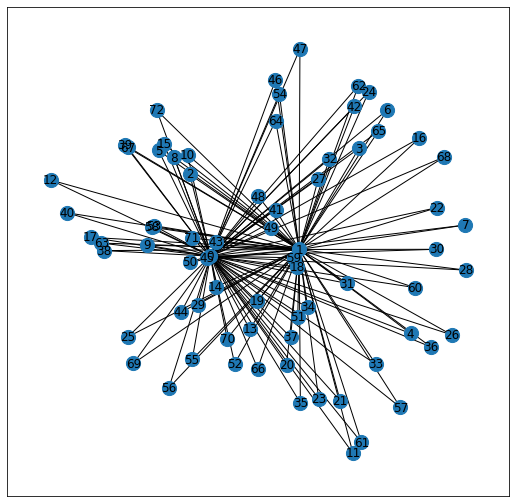

73 73
{'distance': 5843, 'path': ['AMS', 'BOS', 'JFK']}
{'nbRoute': 71, 'path': [['AMS', 'LIM', 'JFK'], ['AMS', 'TLV', 'JFK'], ['AMS', 'MXP', 'JFK'], ['AMS', 'SLC', 'JFK'], ['AMS', 'WAW', 'JFK'], ['AMS', 'MAN', 'JFK'], ['AMS', 'SJO', 'JFK'], ['AMS', 'CUR', 'JFK'], ['AMS', 'BOG', 'JFK'], ['AMS', 'LGW', 'JFK'], ['AMS', 'BOS', 'JFK'], ['AMS', 'DFW', 'JFK'], ['AMS', 'SCL', 'JFK'], ['AMS', 'POS', 'JFK'], ['AMS', 'LIS', 'JFK'], ['AMS', 'DTW', 'JFK'], ['AMS', 'ICN', 'JFK'], ['AMS', 'GIG', 'JFK'], ['AMS', 'AMM', 'JFK'], ['AMS', 'KEF', 'JFK'], ['AMS', 'FRA', 'JFK'], ['AMS', 'BRU', 'JFK'], ['AMS', 'MAD', 'JFK'], ['AMS', 'PTY', 'JFK'], ['AMS', 'CGN', 'JFK'], ['AMS', 'NBO', 'JFK'], ['AMS', 'LHR', 'JFK'], ['AMS', 'EZE', 'JFK'], ['AMS', 'LUX', 'JFK'], ['AMS', 'KWI', 'JFK'], ['AMS', 'JED', 'JFK'], ['AMS', 'BEG', 'JFK'], ['AMS', 'DXB', 'JFK'], ['AMS', 'EMA', 'JFK'], ['AMS', 'ZRH', 'JFK'], ['AMS', 'DOH', 'JFK'], ['AMS', 'CUN', 'JFK'], ['AMS', 'MIA', 'JFK'], ['AMS', 'IAD', 'JFK'], ['AMS', 'SIN', 'JFK'],

In [184]:
def traitementRequest(aeroport_start : str, aeroport_fin : str, g : nx.Graph() = nx.Graph()):
    '''
        fonction qui fait le creation de graphe et qui transofrme les nom de airports en node de graphes
        retour : graphe, list_ref (qui est le lien entre le nombr de nodes et le code de airports)
    '''
    aeroport_codeS = filtreDictAeroports('Name', aeroport_start)[0]
    aeroport_codeE = filtreDictAeroports('Name', aeroport_fin)[0] 
    
    g ,list_ref = nombreDeCorrespondances(g, aeroport_codeS, aeroport_codeE)
    dessinerGraphe(g)
    return g, list_ref
    
def distancePlusCourte(graphe: nx.Graph, list_ref : list, aeroport_codeS, aeroport_codeE):
    '''
        fonction qui trouve le chemin de start aux fin avec le moins de distance possible 
        retour : dictionnaire en forme de {'distance' : .. , 'path' : [ path1, path2 ]}
    '''
    resultat = dijkstra(graphe, list_ref.index(aeroport_codeS), list_ref.index(aeroport_codeE), list_ref)
    return resultat 

def routeAlternatives(graphe : nx.Graph, list_ref : list, int_start : int, int_end : int):
    '''
        fonction qui trouve tous les chemins de start aux fin avec le meme nombr de correspondances 
        que le route plus courte. 
        retour : dictionnaire en forme de {'nbRoute' : .. , 'path' : [ path1, path2 ]}
    '''
    r = list(nx.all_shortest_paths(graphe,source=int_start,target=int_end))    
    tmp = []; 
    for i in r: 
        tmp.append(list(map(lambda x : list_ref[x], i)))
        
    return {"nbRoute" : len(tmp), "path": tmp}

# DUS AAL check
# LAX JFK
# AMS JFK 
a1 = 'AMS' ;  a2 = 'JFK' ; 
s1 = dict_aeroports[a1]['Name']
s2 = dict_aeroports[a2]['Name']

graph, list_reference = traitementRequest(s1, s2)
print(graph.number_of_nodes(), len(list_reference))

print(distancePlusCourte(graph, list_reference, a1, a2)) # route moins de distance 
essai = routeAlternatives(graph, list_reference, list_reference.index(a1), list_reference.index(a2))
print(essai) # autres routes avec le meme nombre de correspondances 


# creation du carte (en utilisation le code de Loris)

In [185]:
def vectGrandCercle(latDep : float, lonDep : float, latArr : float, lonArr : float):
    '''
    Fonction : Calcul un semble de coordonnées permettant de tracer un grand cercle terrestre
    Return : 2 listes de coordonnées
    '''
    g = pyproj.Geod(ellps='WGS84')
    (az12, az21, dist) = g.inv(lonDep, latDep, lonArr, latArr)

    # Coordonnée avec des segments <= 100 km
    lonlats = g.npts(lonDep, latDep, lonArr, latArr,
                    1 + int(dist / 100000))

    #Mise en forme
    v1 = []
    v1.append([latDep,lonDep])
    v2 = []
    _lon = lonDep
    _lat = latDep
    horscadre = False
    for lon, lat in lonlats:
        if(not(horscadre) and Dist(_lat,_lon,lat,lon) < 4):        
            v1.append([lat,lon])
        else:
            horscadre = True
            v2.append([lat,lon])
        _lon = lon
        _lat = lat
    
    if(horscadre):
        v2.append([latArr,lonArr])
    else:
        v1.append([latArr,lonArr])

    return v1,v2

# LORIS ICI :-)

In [195]:
def map_correspondance(path,m):
    Line_monde = f.FeatureGroup(name = "International")
    Line_continent = f.FeatureGroup(name = "Continental")
    Line_pays = f.FeatureGroup(name = "National")   

    for element in range(len(path)-1) :
        #Certains aéroports n'ont pas de correspondance dans le dict. Pour éviter l'erreur -> try puis pass
        try:
            print(path[element], path[element+1])
            start = path[element]
            end = path[element]
            latDep, lonDep = coordDepuisAeroport(start)
            latArr, lonArr = coordDepuisAeroport(end)
            
            #Calcul des chemins à afficher
            v2 = []
            v1,v2 = vectGrandCercle(latDep,lonDep,latArr,lonArr)

            #Test vol national ou international
            if(dict_aeroports[start]['Country'] == dict_aeroports[end]['Country']):
                Line_group = Line_pays
                col_ligne = "#80F0A3"
                col_marker = "#008329"
            elif(dict_pays[dict_aeroports[start]['Country']] == dict_pays[dict_aeroports[end]['Country']] ):
                Line_group = Line_continent
                col_ligne = "#F6FF28"
                col_marker = "#FE7700"
            else:
                Line_group = Line_monde
                col_ligne = "#563DFF"
                col_marker = "#0004A8"


            #-------------------
            f.PolyLine(locations=v1,weight=1, color=col_ligne).add_to(Line_group)
            if(len(v2) != 0):
                f.PolyLine(locations=v2,weight=1, color=col_ligne).add_to(Line_group)
            
            f.CircleMarker(location = [latArr, lonArr],
                            radius = 1, 
                            color = col_marker, 
                            tooltip=dict_aeroports[start]['City'],
                            popup="<b>Nom : </b>" + dict_aeroports[start]['Name'] + """<br />
                                    <b>Code :</b> """ + dict_aeroports[start]['Iata'] + """<br />
                                    <b>Coordonnées :</b> (""" + str(dict_aeroports[start]['Lat']) + ";" + str(dict_aeroports[start]['Lon']) + """)<br />
                                    <b>City : </b>""" + str(dict_aeroports[start]['City']) + """<br />
                                    <b>Pays : </b>""" + dict_aeroports[start]['Country']).add_to(Line_group)
        except:
            pass
    
    finalDestination = path[-1]
    latArr, lonArr = coordDepuisAeroport(finalDestination)
    
    f.CircleMarker(location = [latArr, lonArr],
                            radius = 1, 
                            color = col_marker, 
                            tooltip=dict_aeroports[finalDestination]['City'],
                            popup="<b>Nom : </b>" + dict_aeroports[finalDestination]['Name'] + """<br />
                                    <b>Code :</b> """ + dict_aeroports[finalDestination]['Iata'] + """<br />
                                    <b>Coordonnées :</b> (""" + str(dict_aeroports[finalDestination]['Lat']) + ";" + str(dict_aeroports[finalDestination]['Lon']) + """)<br />
                                    <b>City : </b>""" + str(dict_aeroports[finalDestination]['City']) + """<br />
                                    <b>Pays : </b>""" + dict_aeroports[finalDestination]['Country']).add_to(Line_group)

    #Ajout des layers à la carte
    Line_monde.add_to(m)
    Line_continent.add_to(m)
    Line_pays.add_to(m)

#Paramètre de la carte
m = f.Map(
    location = [0, 0],
    zoom_start = 2.3,
    min_zoom  = 2,
    min_lot=-180,
    max_lot=180,
    min_lat=-90,
    max_lat=90,
    max_bounds=True,
)
f.TileLayer('cartodbdark_matter').add_to(m)

# essai c'est un dict sous la forme de {'nbRoute': 71, 'path': [[path1], [path2], etc]
# donc d'abord je veut essaie de dessiner 1 line (et apres je peut toujours faire une boucle)
# dans essai['path'][0] sont trois code de str : ['AMS', 'LIM', 'JFK']
# donc je veut dessiner un ligne de ams to lim et lim to jfk 

print(essai['path'][0])

map_correspondance(essai['path'][0],m)
f.LayerControl().add_to(m)

m

['AMS', 'LIM', 'JFK']
AMS LIM
LIM JFK


In [187]:
## marche seulement pour les petit relations 
def routeSelonNombreCorrespondances(graphe : nx.Graph, nombre : int, start, end):
    '''
        fonction qui trouve tous les chemins de start aux fin avec 'nombre' correspondances
        retour : dictionnaire en forme de {'nbRoute' : .. , 'path' : [ path1, path2 ]}
    '''
    r2 = list(nx.all_simple_paths(graphe,source=start,target=end))    
    r3 = list(filter(lambda x : len(x) == nombre, r2))
    
    return {"nbRoute" : len(r3), "path": r3}

def routeSelonNombreCorrespondanceLessThen(graphe : nx.Graph, nombre : int, start, end):
    '''
        fonction qui retourne tous les routes/correspondances avec un nombre de correspondances <= nombre 
        retour : un dictionnaire { nombre : {'nbRoute' : .. , 'path' : [ path1, path2 ]}, nombre2 : {..}}
    '''
    r1 = list(nx.all_simple_paths(graphe,source=start,target=end))    
    r2 = list(filter(lambda x : len(x) <= nombre, r1))
    
    return {"nbRoute" : len(r2), "path": r2}

#routeSelonNombreCorrespondanceLessThen(graphe_test, 10, 0,7)

Widget StoryLine 

In [188]:
airportArrive = widgets.Dropdown(
    options= filtreDictAeroports('Name', ''),
    description='Airport Depart:',
    disabled=False,
)

airportDepart = widgets.Dropdown(
    options= filtreDictAeroports('Name', ''),
    description='Airport Depart:',
    disabled=False,
)

recommandationSelon = widgets.RadioButtons(
    options = {'distance', 'CO2', 'alternatives'}, 
    description = 'Recommendation selon : ',
    disable = False, 
)

In [189]:
airportArrive

Dropdown(description='Airport Depart:', options=('A Coruna Airport', 'Aachen Merzbruck Airport', 'Aalborg Airp…

In [190]:
airportDepart

Dropdown(description='Airport Depart:', options=('A Coruna Airport', 'Aachen Merzbruck Airport', 'Aalborg Airp…

In [191]:
recommandationSelon

RadioButtons(description='Recommendation selon : ', options=('alternatives', 'distance', 'CO2'), value='altern…

A Coruna Airport
A Coruna Airport
alternatives
check in nombreDeCorrespondance:  8 73


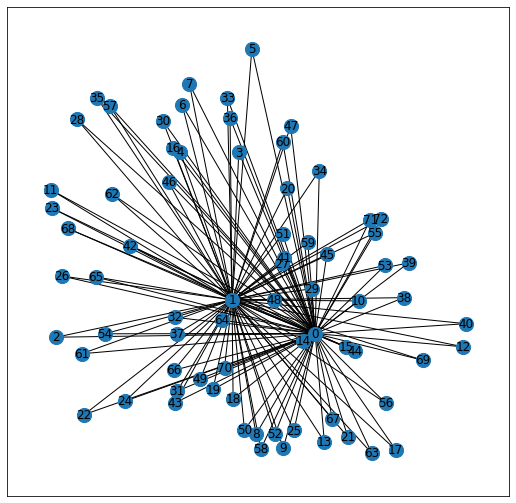

ERROR 


In [192]:
print(airportArrive.value)
print(airportDepart.value)
print(recommandationSelon.value)

codeStart = filtreDictAeroports('Name', airportArrive.value)[0]
codeEnd = filtreDictAeroports('Name', airportDepart.value)[0] 

d = traitementRequest(airportArrive.value, airportDepart.value)

if d[0].number_of_nodes() != len(d[1]):
    print("ERROR ")
else :
    donnees = nettoyageGrapheSiMemeContinent(d[0], d[1], d[1].index(codeStart) ,d[1].index(codeEnd))

    x = donnees[1].index(codeStart)
    y = donnees[1].index(codeEnd)

    if(recommandationSelon.value == 'distance'): print(distancePlusCourte(donnees[0], donnees[1], codeStart, codeEnd))
    if(recommandationSelon.value == 'alternatives'): print(routeAlternatives(donnees[0], donnees[1], x, y))

    print("Nomber of nodes : ", donnees[0].number_of_nodes())
    if(donnees[0].number_of_nodes() < 200):
        print('c\' est un graphe petit donc on peut se permettre de donnee plus de details : ')
        print(routeSelonNombreCorrespondanceLessThen(donnees[0], 5, x , y))


# test dijkstra 

In [193]:
graphe_test = nx.Graph()
returnlist = []

conlist = creationEdges(graphe_test, returnlist, 'AAL', 'LNZ')
conlist.extend(creationEdges(graphe_test, returnlist, returnlist[1], returnlist[3] ))

dessinerGraphe(graphe_test)

#resultat = nx.all_shortest_paths(graphe_test, 0,7)

#r2 = nx.all_simple_paths(graphe_test,source=0,target=7) # peut donner plus des correspondances 
print(routeAlternatives(graphe_test, returnlist, returnlist.index('AAL'), returnlist.index('LNZ')))
#print(list(r2))
resultat = dijkstra(graphe_test, 0, 7, returnlist) # meilleur cas 
#resultat['distance']
resultat['path']

AttributeError: 'tuple' object has no attribute 'extend'

In [ ]:
def routeSelonDistance(graphe : nx.Graph, debut, fin):
    print(nx.dijkstra_path(graphe, debut, fin))

routeSelonDistance(graphe_test, 0,7)